# Classifying tissues from gene expression profiles

A problem clinicians often encounter is the primary origin of cancer. Often, metastatic tumors are never fully diagnosed even after various clinical tests to determine the primary site and are thus labeled cancers of unknown origin (CUP).

RNA-seq data seems like a promising solution to the problem, since tissues differ substantially in their gene expression profiles.

## Exercise:

In this exercise, we will learn how to classify a gene expression count sample into its respective tissue. If there are more than two tissues, we call this a multi-class classification problem.

After you made yourself familiar with the code and the results from our first trained neural network, try out a few things. Here are some guiding questions:

1.   Does the model overfit?
2.   Try to improve the model by changing model width (number of hidden units in a layer) and model depth (number of hidden layers).
3.   Does the model perform equally well for all tissues?





## The data

### Loading the data

We have prepared a small subset from the Genotype-Tissue Expression (GTEx) database. It contains 3382 samples with expression counts from 1000 genes for 7 different tissues. You can see the raw counts below.

In [22]:
!wget https://github.com/Center-for-Health-Data-Science/IntroToML/raw/main/data/gtex_1000.csv.gz

--2022-05-20 14:36:30--  https://github.com/Center-for-Health-Data-Science/IntroToML/raw/main/data/gtex_1000.csv.gz
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Center-for-Health-Data-Science/IntroToML/main/data/gtex_1000.csv.gz [following]
--2022-05-20 14:36:31--  https://raw.githubusercontent.com/Center-for-Health-Data-Science/IntroToML/main/data/gtex_1000.csv.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9481366 (9.0M) [application/octet-stream]
Saving to: ‘gtex_1000.csv.gz.1’

gtex_1000.csv.gz.1  100%[===================>]   9.04M  4.81MB/s    in 1.9s    

2022-05-20 14:36:33 (4.81 M

In [23]:
import pandas as pd

gtex_raw = pd.read_table("gtex_1000.csv.gz",sep='\t')
gtex_raw

,ENSG00000122591.11,ENSG00000110934.10,ENSG00000112303.13,ENSG00000243943.9,ENSG00000200320.1,ENSG00000185523.6,ENSG00000002016.17,ENSG00000196290.14,ENSG00000171824.13,ENSG00000115459.17,...,ENSG00000180011.6,ENSG00000164124.10,ENSG00000244734.3,ENSG00000187581.2,ENSG00000213339.8,ENSG00000130165.10,ENSG00000005801.16,ENSG00000185915.5,ENSG00000144560.14,tissue
0,405969,7207,1849,76326,1137,0,57752,48599,283994,103733,...,327448,5471,18465,350,168016,132203,77422,155460,166033,Muscle - Skeletal
1,110743,4954,4145,59331,1421,0,44751,47289,130585,80527,...,302126,9517,534500,912,84383,36860,70953,22257,119196,Muscle - Skeletal
2,601549,5079,4575,122535,1548,0,74709,88950,382542,292433,...,270768,12160,176390,447,103221,206666,138026,80034,140739,Muscle - Skeletal
3,107785,4251,992,48109,263,0,32903,61342,187242,103506,...,154879,3359,232653,223,57992,99642,55399,26447,34862,Muscle - Skeletal
4,104541,2725,1358,37434,793,0,123826,45624,276829,101146,...,246964,2494,518473,705,120504,111607,46009,227114,144601,Muscle - Skeletal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3377,79761,19768,10206,156399,9039,208,122848,62718,314624,192105,...,195498,52029,734385,14,959388,229488,107154,123,329118,Pancreas
3378,20851,2991,2527,35698,2716,274,31757,21671,99782,59068,...,78579,17461,384240,0,338844,111479,44852,10,82292,Pancreas
3379,56853,8709,9006,93894,5211,0,64820,43218,176857,77350,...,140115,65180,3694,377,305473,112569,98811,267,197824,Pancreas
3380,52879,9946,6180,136779,7409,264,96992,35492,214014,127169,...,198793,54667,362916,228,557786,124295,111535,0,290844,Pancreas


As you can see in the las column of the dataframe, the tissues are enconded as strings, and pytorch does not support this. To address so, we will simply encode the tissues as numbers. Luckily, sklearn has a function for that! See the before and after below.

In [24]:
# tissues before transform
print('tissues before \n', gtex_raw['tissue'])

# transforming strings to integer labels
gtex = gtex_raw.copy()
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(gtex['tissue'])
gtex['tissue'] = le.transform(gtex['tissue'])

# tissues after transform
print('tissues after \n', gtex['tissue'])

tissues before 
 0       Muscle - Skeletal
1       Muscle - Skeletal
2       Muscle - Skeletal
3       Muscle - Skeletal
4       Muscle - Skeletal
              ...        
3377             Pancreas
3378             Pancreas
3379             Pancreas
3380             Pancreas
3381             Pancreas
Name: tissue, Length: 3382, dtype: object
tissues after 
 0       4
1       4
2       4
3       4
4       4
       ..
3377    5
3378    5
3379    5
3380    5
3381    5
Name: tissue, Length: 3382, dtype: int64


### An initial exploration of the data using PCA

Before diving "deep" into a neural network, we will explore the data a bit using a principal component analysis (PCA). This will serve as a good baseline to see how easy it is to (linearly) separate the tissues from the data. In this way, we can have an initial guess how complex our model should be.

Due to the extreme range of the expression counts, we log-transform the data before visualizing it in a PCA to get a "clearer visual".

In [25]:
import numpy as np
from sklearn.decomposition import PCA

# log scale the data
x = gtex.loc[:, gtex.columns.drop('tissue')].values
x = np.log(x+0.01) # add pseudo-counts

# fit pca 
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)
df_pca = pd.DataFrame(data = principal_components
             , columns = ['principal component 1', 'principal component 2'])

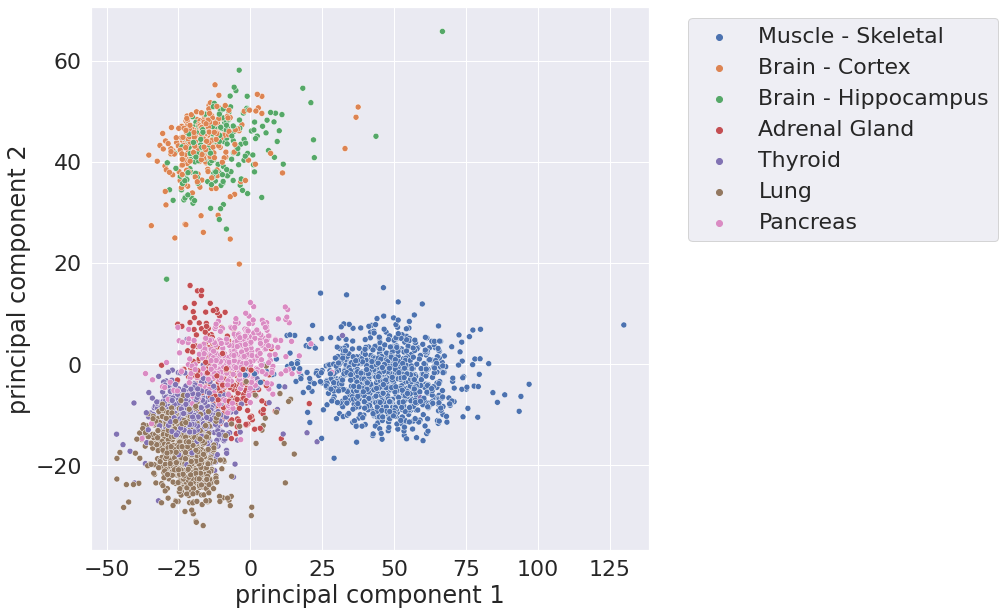

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 2)

# add the original tissue strings to the PCA data
df_pca['tissue'] = gtex_raw['tissue'].values

fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=df_pca, x='principal component 1', y='principal component 2', hue='tissue', ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1.), loc='upper left')
plt.show()

From the PCA, it becomes apparent that tissues have different gene expression profiles. Let's try to create a neural network that classifies the samples given the gene expression values.

### Preliminaries: preparing the data for pytorch

Pytorch has certain requirements that datasets need to fulfill. We don't have to bother with the details, though. The Dataset module takes care of things for us, we just need to use it to specify what the input and what the output is, and how to get samples from it.

In more detail, since datasets can be of different types, we need to create new class functions for making the dataset (\__init__\()), telling us how many samples there are (\__len__\()), and accessing samples by index (\__getitem__\()).

In [30]:
import torch
from torch.utils.data import Dataset, DataLoader

class GeneExpressionDataset(Dataset):
    '''
    Creates a Dataset class for gene expression dataset
    gene_dim is the number of genes (features)
    The rows of the dataframe contain samples, and the 
    columns contain gene expression values 
    and the class label (tissue) at label_position.
    '''
    def __init__(self, gtex, label_position=-1):
        '''
        Args:
            gtex: pandas dataframe containing input and output data
            label_position: column id of the class labels
        '''
        self.dataframe = gtex
        self.label_position = label_position

        # convert labels to numbers
        self.le = preprocessing.LabelEncoder()
        self.label = self.le.fit_transform(self.dataframe.iloc[:,label_position])#.values
        self.data = torch.tensor(self.dataframe.drop(self.dataframe.columns[[self.label_position]], axis=1).values).float()
        
    def __len__(self):
        return(len(self.dataframe))
    
    def __getitem__(self, idx):
        # get expression and labels
        expression = self.data[idx,:]
        label = self.label[idx]
        return expression, label

## The neural network

Once we have defined our dataset, we need to define our neural network. 

In [70]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # 2 fully connected layers 
        self.fc1 = nn.Linear(in_features=1000, out_features=200)
        self.fc2 = nn.Linear(in_features=200, out_features=7)

    def forward(self, x):
        # pass data through the layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Training

Finally, we can move to the main part. We first create a train and test set from the data. This is important for knowing how the model performs on unseen samples from the same "distribution".

We then use these two sets to make so-called dataloaders. These essentially take care of splitting the data into randomly grouped subsets (they are called mini-batches).

After that we initialize the network and define the criterion, aka the loss function, and the optimizer that will update the model weights for us.

In [71]:
from sklearn.model_selection import train_test_split
from torch import optim

train, test = train_test_split(gtex,test_size=0.2,random_state=42)

gtex_train = GeneExpressionDataset(train)
gtex_test = GeneExpressionDataset(test)
batch_size = 32
train_loader = torch.utils.data.DataLoader(gtex_train, batch_size=batch_size, num_workers=0, shuffle=True)
test_loader = torch.utils.data.DataLoader(gtex_test, batch_size=batch_size, num_workers=0, shuffle=True)

epochs = 20

net = Net()
criterion = nn.CrossEntropyLoss(reduction='mean') # mean is default
optimizer = optim.Adam(net.parameters(), lr=0.0001)

Now we can finally start training!

In [72]:
# in these lists we store loss and accuracy per epoch to keep track of the progress
train_loss = []
test_loss = []
train_acc = []
test_acc  = []

for epoch in range(epochs):
    # for each epoch we collect the stats as averages over the mini-batches
    epoch_train_loss = 0.0
    epoch_test_loss = 0.0
    epoch_train_acc = 0.0
    epoch_test_acc = 0.0
    
    # train
    for inputs,labels in train_loader:
        
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + loss
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        epoch_train_loss += loss.item()
        # backward
        loss.backward()
        # optimize
        optimizer.step()

        # calculate train accuracy
        correct_pred = outputs.argmax(dim=1) == labels
        acc = correct_pred.sum() / len(correct_pred)
        epoch_train_acc += acc.item()

    # test
    for inputs,labels in test_loader:

        # forward only
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        epoch_test_loss += loss.item()
        
        correct_pred = outputs.argmax(dim=1) == labels
        acc = correct_pred.sum() / len(correct_pred)
        epoch_test_acc += acc.item()
        
    # average the stats and append to lists
    epoch_train_loss /= len(train_loader)
    epoch_test_loss /= len(test_loader)
    epoch_train_acc /= len(train_loader)
    epoch_test_acc /= len(test_loader)
    train_loss.append(epoch_train_loss)
    test_loss.append(epoch_test_loss)
    train_acc.append(epoch_train_acc)
    test_acc.append(epoch_test_acc)
                                
    print("Epoch:", epoch)
    print("train loss:", round(epoch_train_loss, 4),"test loss:", round(epoch_test_loss, 4))
    print("train acc:", round(epoch_train_acc, 4),"test accuracy:", round(epoch_test_acc, 4))

Epoch: 0
train loss: 53120.4183 test loss: 1640.5781
train acc: 0.8419 test accuracy: 0.9759
Epoch: 1
train loss: 1059.3872 test loss: 1457.4003
train acc: 0.985 test accuracy: 0.9801
Epoch: 2
train loss: 748.1914 test loss: 1441.0361
train acc: 0.9868 test accuracy: 0.9815
Epoch: 3
train loss: 511.2166 test loss: 1343.5262
train acc: 0.9897 test accuracy: 0.9901
Epoch: 4
train loss: 373.7292 test loss: 2190.3778
train acc: 0.9915 test accuracy: 0.9645
Epoch: 5
train loss: 328.6198 test loss: 1546.9003
train acc: 0.9893 test accuracy: 0.9773
Epoch: 6
train loss: 199.2309 test loss: 1431.6386
train acc: 0.9941 test accuracy: 0.9886
Epoch: 7
train loss: 240.1492 test loss: 1701.4391
train acc: 0.9949 test accuracy: 0.9858
Epoch: 8
train loss: 134.3387 test loss: 1412.0723
train acc: 0.996 test accuracy: 0.9901
Epoch: 9
train loss: 111.0144 test loss: 1332.026
train acc: 0.996 test accuracy: 0.9901
Epoch: 10
train loss: 134.9062 test loss: 1468.2444
train acc: 0.9941 test accuracy: 0.9801

Lets now plot the loss curves

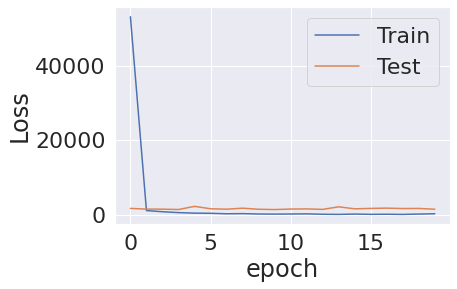

In [73]:
plt.plot(np.arange(epoch+1),train_loss,label="Train")
plt.plot(np.arange(epoch+1),test_loss,label="Test")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.show()

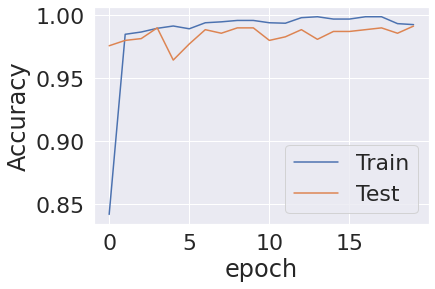

In [74]:
plt.plot(np.arange(epoch+1),train_acc,label="Train")
plt.plot(np.arange(epoch+1),test_acc,label="Test")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.show()